Comparing the Performance of Pipelines
===

Author: Nathan A. Mahynski

Date: 2023/08/31

Description: How can we determine which models or pipelines are actually better than each other?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/comparing_pipelines.ipynb)

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [2]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [3]:
import sklearn
import imblearn
import numpy as np

from sklearn.model_selection import GridSearchCV

from pychemauth.classifier.simca import SIMCA_Authenticator
from pychemauth.manifold.elliptic import EllipticManifold_Authenticator
from pychemauth.classifier.plsda import PLSDA
from pychemauth.analysis.compare import Compare

In [4]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-34-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

pychemauth: 0.0.0b3
matplotlib: 3.7.2
numpy     : 1.24.3
imblearn  : 0.11.0
sklearn   : 1.3.0
watermark : 2.4.3



<h3>Load the Data</h3>

In [5]:
from sklearn.datasets import load_iris as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [6]:
# Let's turn the indices into names
names = dict(zip(np.arange(3), ['setosa', 'versicolor', 'virginica'])) 
y = y.apply(lambda x: names[x])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values, # Let's try to predict the salary based on the other numerical features.
    shuffle=True,
    random_state=0,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

Comparing Several Models
---

Importantly, we need to estimate the generalization error on, not only the model, but also the model's hyperparameter search.
To do this we will use GridSearchCV objects equipped with parameter grids to optimize their hyperparameters over.  Each time
`.fit()` is called on such an object it will optimize the hyperparameters using internal k-fold CV then refit on the entire
training set it is given.  

We will use pychemauth's built in `repeated_kfold` function to repeatedly shuffle and split the data and fit each pipeline on that chunk of data.  By passing GridSearchCV objects we are really doing repeated, nested CV. This allows us to perform a (corrected) paired t-test to see if model differences are statistically significant.  We need to be sure to do enough tests to have confidence in our results, so usually this is recommended to be 10 repeats of 10-fold CV.  The k used for internal hyperparameter optimization should be sufficient to yield reasonable results.

In [8]:
compliant_ddsimca = imblearn.pipeline.Pipeline(
    steps=[
        ("simca", SIMCA_Authenticator(
            n_components=1, 
            alpha=0.05, 
            scale_x=True, 
            style='dd-simca', 
            target_class='setosa', 
            use='compliant'
        )
    )
])

param_grid = [{
    'simca__n_components':np.arange(1, 4),
    'simca__alpha': [0.001, 0.01, 0.1, 0.5]
}]

gs_compliant_ddsimca = GridSearchCV(
    estimator=compliant_ddsimca,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    error_score=0, # If a model fails to fit it is given a score of 0
    refit=True
)

In [9]:
compliant_simca = imblearn.pipeline.Pipeline(
    steps=[
        ("simca", SIMCA_Authenticator(
            n_components=1, 
            alpha=0.05, 
            scale_x=True, 
            style='simca', 
            target_class='setosa', 
            use='compliant'
        )
    )
])

param_grid = [{
    'simca__n_components':np.arange(1, 4),
    'simca__alpha': [0.001, 0.01, 0.1, 0.5]
}]

gs_compliant_simca = GridSearchCV(
    estimator=compliant_simca,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    error_score=0, # If a model fails to fit it is given a score of 0
    refit=True
)

In [10]:
compliant_em = imblearn.pipeline.Pipeline(
    steps=[
        ("model", EllipticManifold_Authenticator(
            alpha=0.05, 
            dr_model=sklearn.decomposition.PCA, # A linear approach
            kwargs={'n_components':1}, # Keywords for the dr_model
            ndims='n_components', # The keyword that corresponds to the dimensionality of space
            robust=True, # Estimate the covariance matrix for the Mahalanobis distance using a robust approach
            center='score', # Center the ellipse around the emperical mean of the projected data
            target_class='setosa', # Tell the classifier which class to use
            use='compliant' # Using a compliant approach will use the other classes provided at training time
        )
    )
])

param_grid = [{
    'model__kwargs':[{'n_components':i} for i in [1, 2, 3, 4]],
    'model__alpha': [0.001, 0.01, 0.1, 0.5]
}]

gs_compliant_em = GridSearchCV(
    estimator=compliant_em,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    error_score=0, # If a model fails to fit it is given a score of 0
    refit=True
)

In [11]:
pipeline_plsda = imblearn.pipeline.Pipeline(
    steps=[
        ("plsda", PLSDA(
            n_components=5, 
            alpha=0.05,
            scale_x=True, 
            not_assigned='UNKNOWN',
            style='soft', 
            score_metric='TEFF'
        )
    )
])

param_grid = [{
    'plsda__n_components':[3, 4],
    'plsda__alpha': [0.001, 0.01, 0.1, 0.5],
}]

gs_plsda = GridSearchCV(
    estimator=pipeline_plsda,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    error_score=0, # If a model fails to fit it is given a score of 0
    refit=True
)

In [13]:
scores1, scores2, scores3, scores4 = Compare.repeated_kfold(
    [
        gs_compliant_ddsimca, 
        gs_compliant_simca,
        gs_compliant_em,
        gs_plsda,
    ], 
    X_train, 
    y_train, 
    n_repeats=10, 
    k=10, 
    random_state=0,
)

Computing and Visualizing Statistically Significant Differences
---

Recall that soft PLS-DA has a slightly different definition for TSPS, which means that its TEFF is not computed the same way as the other models.  It is important to remember to compare "apples to apples", but this suffices for an example.  Here, all models are highly performant.

In [14]:
# No bad fits
for score in [scores1, scores2, scores3, scores4]:
    print(np.sum(score == 0))

0
0
0
0


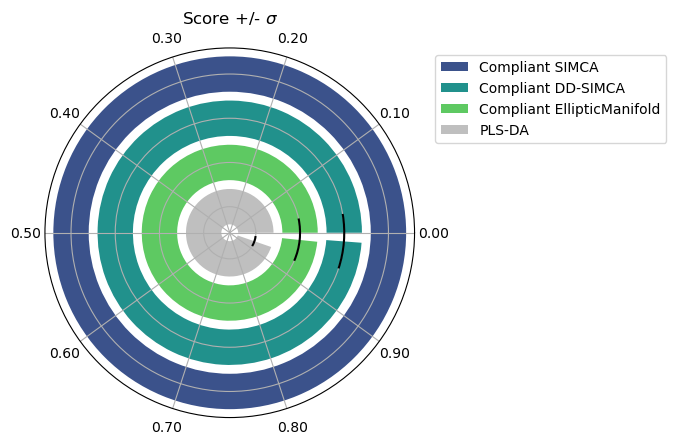

In [15]:
_ = Compare.visualize(
    {
        'Compliant DD-SIMCA': scores1,
        'Compliant SIMCA': scores2,
        'Compliant EllipticManifold': scores3,
        'PLS-DA': scores4
    },
    n_repeats=10,
    alpha=0.05,
    ignore=0 # Ignore any failed fits
)

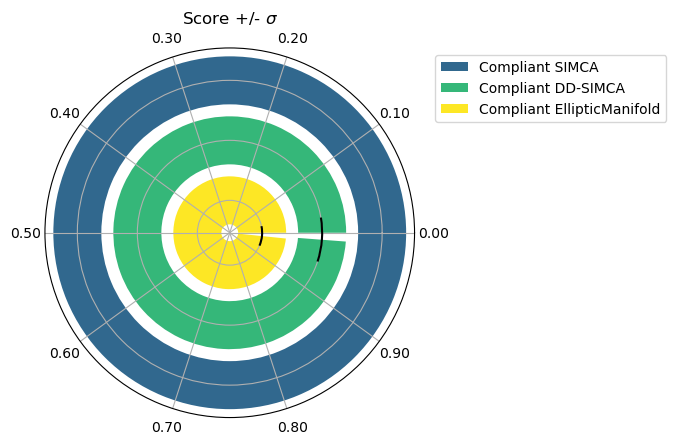

In [16]:
_ = Compare.visualize(
    {
        'Compliant DD-SIMCA': scores1,
        'Compliant SIMCA': scores2,
        'Compliant EllipticManifold': scores3,
    },
    n_repeats=10,
    alpha=0.05,
    ignore=0
)